In [1]:
#!/usr/bin/env python3
import os
import re
import sys
import collections
import argparse
import tables
import glob
import itertools
import math

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sp_sparse

from multiprocessing import Pool
from collections import defaultdict
from scipy import sparse, io
from scipy.sparse import csr_matrix
from multiprocessing import Pool

import matplotlib.pyplot as plt
import networkx as nx
import pycircos
Garc    = pycircos.Garc
Gcircle = pycircos.Gcircle

import scanpy as sc

In [2]:
SAVE_DIR = '/project/GCRB/Hon_lab/s426305/Analysis/Mosaic-seq/Module_analysis/'

## Slice GWAS regions from the pert_cpm_df

In [2]:
FILE_DIR = '/project/GCRB/Hon_lab/s426305/Sequencing_data_analysis/10X/DAA271-DAA286-ER+screens/process_singlets/MB361/'
singlet_mtx = sc.read(FILE_DIR + 'sinlget_mtx.h5ad')

In [10]:
GWAS_annot = '/project/GCRB/Hon_lab/s426305/Analysis/Mosaic-seq/MB231-dCas9-KRAB+YWsg1P3/enhancer_regions_combined.txt'
SM_annot = '/project/GCRB/Hon_lab/s426305/Analysis/Mosaic-seq/MB231-dCas9-KRAB+YWsg2P1/annotation/enhancer_regions_hg38.txt'
GWAS_dict  = {}
SM_dict = {}
with open(GWAS_annot) as f:
    for line in f:
        region_id, sgrna_string = line.strip().split('\t')
        sgrnas = sgrna_string.split(';')
        GWAS_dict.update({region_id : [i.upper() for i in sgrnas]})
        
with open(SM_annot) as f:
    for line in f:
        region_id, sgrna_string = line.strip().split('\t')
        sgrnas = sgrna_string.split(';')
        SM_dict.update({region_id : [i.upper() for i in sgrnas]})      

In [11]:
print(len(GWAS_dict))
print(len(SM_dict))

2038
1475


In [12]:
pert_cpm_df = pd.read_csv('./Pert_cpm_df.csv', index_col=0)

In [13]:
GWAS_pert_cpm_df = pert_cpm_df[list(GWAS_dict.keys())]

In [14]:
plot_gene_idx = np.load('/project/GCRB/Hon_lab/s426305/Analysis/Mosaic-seq/MB361-GWAS+SM/rand_cell/MB361-5perc_expre_gene_idx.npy')

#### Filter with genes expressed in at least 5% of cells

In [15]:
GWAS_pert_cpm_df.iloc[plot_gene_idx, :]

,chr10:112811644-112812144,chr10:112815533-112816033,chr10:112821603-112822103,chr10:112919653-112920153,chr10:112949881-112950381,chr10:112963748-112964248,chr10:112981494-112981994,chr10:113069526-113070026,chr10:113073659-113074159,chr10:113087239-113087739,...,chr9:133375934-133376434,chr9:133459404-133459904,chr9:133459770-133460270,chr9:133478926-133479426,chr9:133506497-133506997,chr9:133509865-133510365,chr9:133522366-133522866,chr9:133522577-133523077,chr9:133691655-133692155,chr9:133714764-133715264
RP5-857K21.9,10.917879,10.592329,10.706647,10.358738,8.616899,10.554336,9.947975,9.201864,9.581009,11.849035,...,9.558113,8.007029,11.617649,9.581151,10.552535,10.078905,9.213407,10.123085,10.293813,9.730851
RP5-857K21.6,18.640798,17.979494,21.720378,20.472756,20.029119,22.658825,19.767692,20.149126,21.287650,19.563389,...,18.298101,21.767993,21.293285,20.801024,21.928338,20.946125,22.032092,21.377153,18.078329,18.968828
RP5-857K21.10,312.556649,312.244668,324.995038,326.443968,320.046300,323.559176,322.924235,318.284702,326.797675,311.486755,...,316.947628,322.685172,317.298716,322.406914,317.371507,324.952750,326.272781,319.035757,318.324317,318.984848
RP11-206L10.11,7.865440,8.727799,7.690275,8.550148,7.532109,8.093647,8.457434,7.555815,9.169430,8.852280,...,7.915614,6.890146,9.097110,8.693162,8.719850,7.545997,9.287802,8.711403,8.792503,8.623838
SAMD11,7.983927,9.256808,9.459809,8.620245,7.819133,6.983210,8.859422,10.280992,9.891186,7.602883,...,8.490279,8.031922,7.190722,9.932370,9.737427,9.134040,8.261827,8.804177,8.678541,9.851158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MT-ND5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MT-ND6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MT-CYB,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [16]:
adata = sc.AnnData(GWAS_pert_cpm_df.iloc[plot_gene_idx, :].T, 
    GWAS_pert_cpm_df.iloc[plot_gene_idx, :].T.index.to_frame(), 
    GWAS_pert_cpm_df.iloc[plot_gene_idx, :].T.columns.to_frame())

In [17]:
adata

AnnData object with n_obs × n_vars = 2038 × 9656
    obs: 0
    var: 0

In [18]:
#use recipe from Zheng et al
sc.pp.recipe_zheng17(adata, n_top_genes = 1000)

# Transpose: gene based clustering

In [19]:
transpose_singlet_mtx = adata.transpose()

## PCA

In [20]:
sc.tl.pca(transpose_singlet_mtx,
          n_comps=50,
          random_state=0)

In [21]:
transpose_singlet_mtx

AnnData object with n_obs × n_vars = 1000 × 2038
    obs: 0, 'n_counts', 'mean', 'std'
    var: 0, 'n_counts_all'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

### Compute a neighborhood graph of observations

In [22]:
sc.pp.neighbors(
    transpose_singlet_mtx,
    n_neighbors=15,
    use_rep='X_pca'
)

### UMAP visualization

In [23]:
sc.tl.umap(transpose_singlet_mtx, 
          random_state=0)

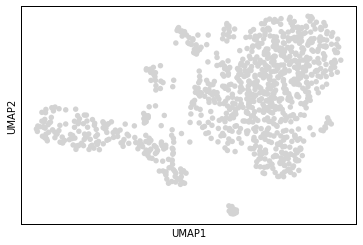

In [24]:
sc.pl.umap(transpose_singlet_mtx)

### Louvain clustering

In [25]:
sc.tl.louvain(
    transpose_singlet_mtx,
    resolution=0.5) #higher resolution, more clusters

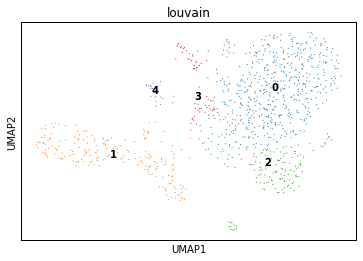

In [26]:
sc.pl.umap(
        transpose_singlet_mtx, 
        color=['louvain'],
        size=5, 
        legend_loc='on data')

### PAGA

In [27]:
sc.tl.paga(
    transpose_singlet_mtx,
    groups='louvain',  
)

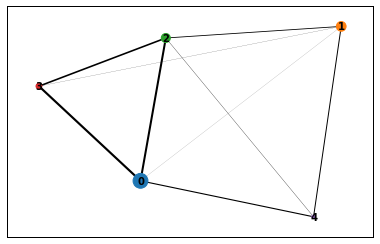

In [28]:
sc.pl.paga(
    transpose_singlet_mtx, 
    color=['louvain'], 
    use_raw=True,
#    use_raw=False,
#    layout='fa', 
    layout='fr', 
    threshold=0.01, 
    node_size_scale=0.5,
    node_size_power=0.9, 
#    random_state=random_seed, 
)

In [29]:
sc.tl.umap(
    transpose_singlet_mtx,
    init_pos='paga', 
#    random_state=random_seed,
)

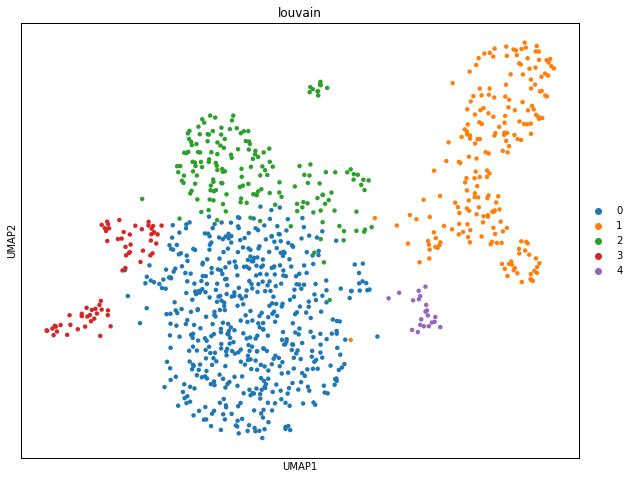

In [31]:
fig, ax = plt.subplots(figsize=(10,8))
sc.pl.umap(transpose_singlet_mtx, 
          color=['louvain'],
          size=80, 
          ax=ax,
          save='MB361_GWAS_gene_program_UMAP.png'
          )

In [33]:
del adata.obs[0]
del adata.var[0]

In [35]:
adata.var['program_louvain'] = transpose_singlet_mtx.obs['louvain']

# Perturbation based clustering

In [36]:
adata

AnnData object with n_obs × n_vars = 2038 × 1000
    obs: 'n_counts_all'
    var: 'n_counts', 'mean', 'std', 'program_louvain'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'paga', 'louvain_sizes'

## PCA

In [37]:
sc.tl.pca(adata,
          n_comps=50,
          random_state=0)

In [38]:
adata

AnnData object with n_obs × n_vars = 2038 × 1000
    obs: 'n_counts_all'
    var: 'n_counts', 'mean', 'std', 'program_louvain'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors', 'paga', 'louvain_sizes'
    obsm: 'X_pca'
    varm: 'PCs'

### Compute a neighborhood graph of observations

In [39]:
sc.pp.neighbors(
    adata,
    n_neighbors=15,
    use_rep='X_pca'
)

### UMAP visualization

In [40]:
sc.tl.umap(adata, 
          random_state=0)

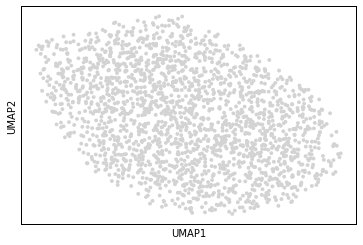

In [41]:
sc.pl.umap(adata)

### Try tsne

In [42]:
sc.tl.tsne(adata, 
          random_state=0)

/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


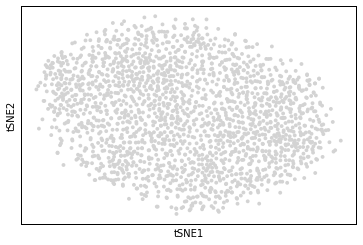

In [43]:
sc.pl.tsne(adata)

### Louvain clustering

In [44]:
sc.tl.louvain(
    adata,
    resolution=0.5) #higher resolution, more clusters

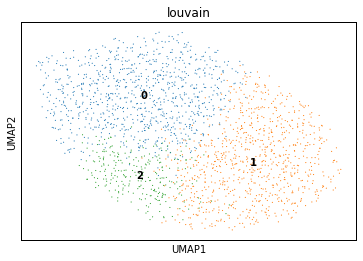

In [45]:
sc.pl.umap(
        adata, 
        color=['louvain'],
        size=5, 
        legend_loc='on data')

### PAGA

In [46]:
sc.tl.paga(
    adata,
    groups='louvain',  
)

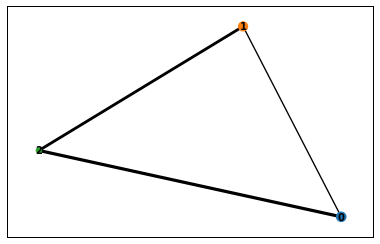

In [47]:
sc.pl.paga(
    adata, 
    color=['louvain'], 
    use_raw=True,
#    use_raw=False,
#    layout='fa', 
    layout='fr', 
    threshold=0.01, 
    node_size_scale=0.5,
    node_size_power=0.9, 
#    random_state=random_seed, 
)

In [48]:
sc.tl.umap(
    adata,
    init_pos='paga', 
#    random_state=random_seed,
)

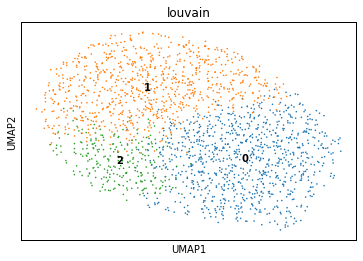

In [49]:
sc.pl.umap(
        adata, 
        color=['louvain'],
        size=10, 
        legend_loc='on data')

In [32]:
adata = sc.read_h5ad('./11GWASmodule_adata.h5ad')

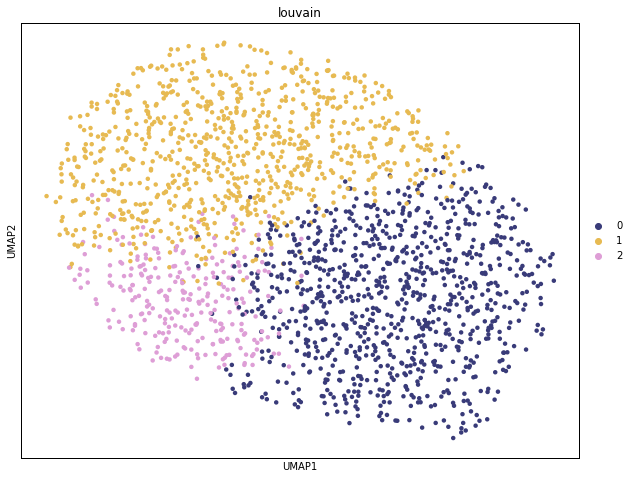

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
sc.pl.umap(adata, 
           color=['louvain'],
           palette='tab20b', 
           size=80, 
           ax=ax,
           save='MB361_GWAS_perturbation_module_v2.png'
           )

## combine gene based clustering and perturbation based clustering to plot heatmap

In [3]:
adata = sc.read_h5ad('./11GWASmodule_adata.h5ad')

In [9]:
adata.var

,n_counts,mean,std,program_louvain
ISG15,2.398497e+05,4.771952,0.094073,0
MXRA8,1.440196e+05,4.270882,0.048328,0
RP3-395M20.12,5.422905e+04,3.315774,0.069710,0
SMIM1,9.189962e+04,3.829028,0.057657,0
PER3,1.438370e+05,4.269694,0.048080,0
...,...,...,...,...
TSC22D3,7.402379e+04,3.617122,0.070193,3
FGF13,3.257303e+04,2.828566,0.085575,0
HMGB3,2.361511e+05,4.760096,0.046126,1
FLNA,3.058179e+05,5.017027,0.036573,0


In [13]:
obs_df = pd.DataFrame(index=adata.var_names, data={'program_louvain': adata.var['program_louvain'].values})
var_df = pd.DataFrame(index=adata.obs_names, data={'louvain': adata.obs['louvain'].values})
sorted_obs = obs_df.sort_values(by=['program_louvain'])
sorted_var = var_df.sort_values(by=['louvain'])

In [14]:
# create the sorted AnnData object
step1_df = adata.transpose()[:, sorted_var.index]
sorted_adata = step1_df[sorted_obs.index, :]

/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log1p
  after removing the cwd from sys.path.


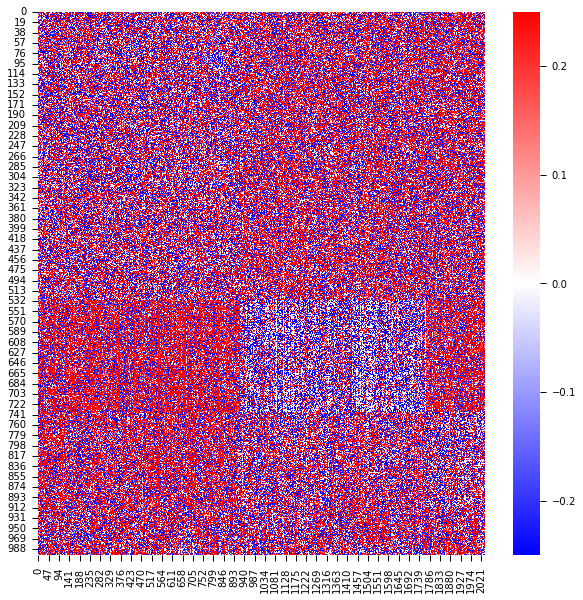

In [27]:
# plot the heatmap
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(np.log1p(sorted_adata.X), cmap='bwr', ax=ax, vmax=0.25, vmin=-0.25, rasterized=True)
#plt.show()
plt.savefig(SAVE_DIR + 'MB361_GWAS_module_program_heatmap_v2.pdf')

In [48]:
for i in adata.var[adata.var['program_louvain'] == '2'].index:
    print(i)

ENO1
TCEA3
EVA1B
CITED4
AK4
VAV3
CRABP2
TAGLN2
NOS1AP
RGS16
LIN9
MBOAT2
ODC1
GREB1
BCYRN1
WDR54
AFF3
RPL37A
IRS1
HES6
MYEOV2
KIF1A
BHLHE40
ARPP21
FLNB
CMSS1
RABL3
FAM162A
SIAH2
TNIK
C4orf3
TBC1D9
PALLD
BASP1
PRLR
IL6ST
MAP1B
NR2F1
RHOBTB3
STC2
STMND1
RBM24
CAP2
CLPSL2
VEGFA
HSP90AB1
C6orf141
EEF1A1
TPBG
AMD1
PKIB
TPD52L1
RPS12
ARMT1
CCDC170
ESR1
AGR3
VSTM2A
SEC61G
EGFR
HSPB1
CD36
TFPI2
CTTNBP2
AGPAT5
STC1
BNIP3L
DPYSL2
SGK3
FABP5
RAD54B
LAPTM4B
TRPS1
MYC
NDRG1
KIF24
DCAF10
FGD3
AMBP
KIF12
RPL7A
GATA3
RP11-428L9.2
SUV39H2
ANK3
P4HA1
SNCG
MYOF
GFRA1
BNIP3
CTSD
FTH1
ALDH3B2
GAL
RAB30
PRSS23
PGR
GAPDH
PTMS
TPI1
ENO2
H2AFJ
MGP
ARHGDIB
RERG
LDHB
RASSF8
AMIGO2
TUBA1A
GALNT6
FRS2
SYT1
ATP2B1
C12orf75
TBX3
HSPB8
UBL3
HSPH1
CTD-2314B22.1
EGLN3
HIF1A
IFI27L2
SERPINA6
SERPINA1
EVL
DEGS2
HSP90AA1
CKB
CRIP1
CEP152
CA12
RPLP1
THSD4
LINC00052
IGF1R
HAGHL
RPUSD1
RPS2
RP11-304L19.5
RP11-473M20.16
ABAT
SULT1A1
SLC7A5
RPL13
RABEP1
TRIM16L
RPL23
RPL19
IGFBP4
RP11-329L6.2
SLC9A3R1
SRSF2
ACTG1
RAB31
PMAIP1
B

In [60]:
adata.write('./11GWASmodule_adata.h5ad')

## Correlation

In [39]:
perturbation_covariance_df = pd.read_csv('./GWAS_Perturb_covariance_df.csv', index_col=0)

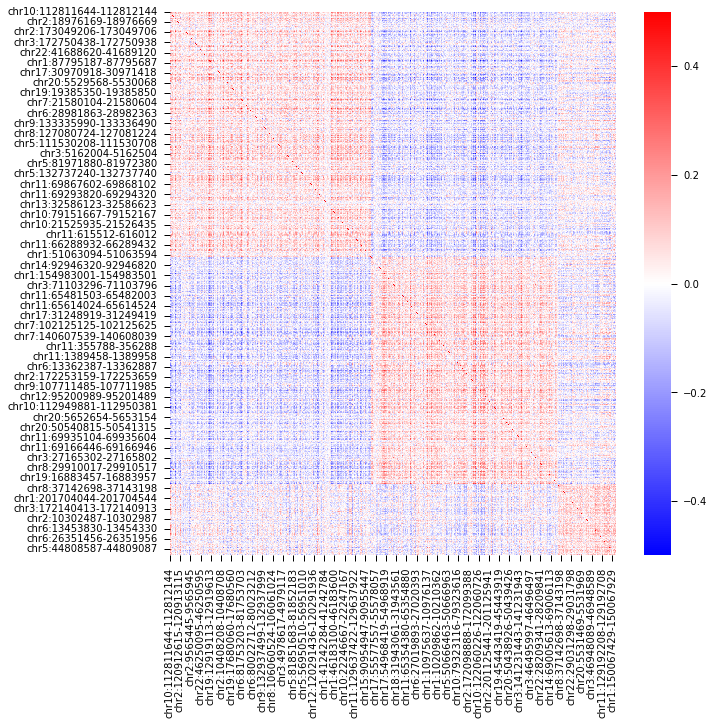

In [41]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(perturbation_covariance_df.astype(float), cmap='bwr', ax=ax, vmax=0.5, vmin=-0.5, rasterized=True)
plt.savefig(SAVE_DIR + 'MB361GWAS_perturbation_correlation.pdf')

In [42]:
gene_covariance_df = pd.read_csv('./GWAS_Gene_covariance_df.csv', index_col=0)

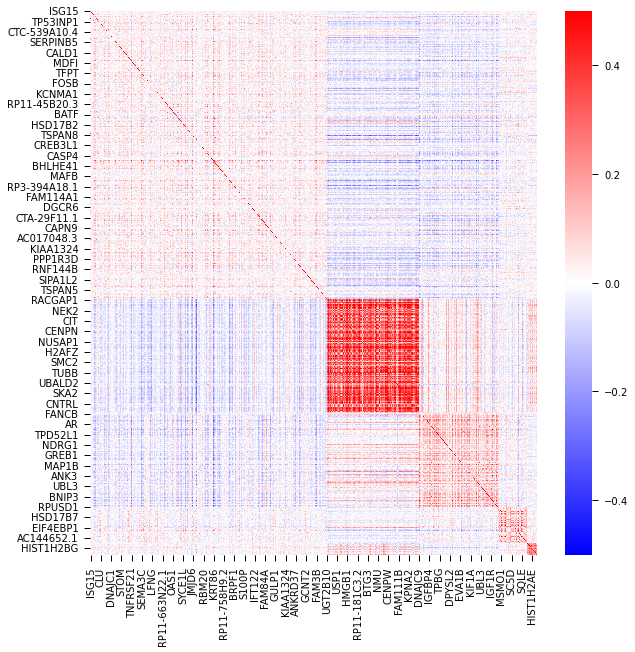

In [44]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(gene_covariance_df.astype(float), cmap='bwr', ax=ax, vmax=0.5, vmin=-0.5, rasterized=True)
#plt.show()
plt.savefig(SAVE_DIR + 'MB361GWAS_gene_correlation.pdf')

(array([  2.,  13.,  70., 136., 209., 286., 193.,  67.,  20.,   4.]),
 array([-3.1273692 , -2.5306957 , -1.9340223 , -1.3373488 , -0.7406754 ,
        -0.14400196,  0.45267147,  1.0493449 ,  1.6460184 ,  2.2426918 ,
         2.8393652 ], dtype=float32),
 <BarContainer object of 10 artists>)

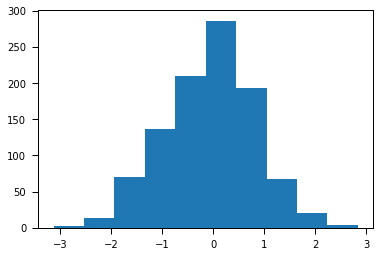

In [25]:
plt.hist(adata.X[3])

In [21]:
np.sum(adata.X, axis=0)

array([ 1.11758709e-05, -2.88784504e-05, -1.78813934e-07,  4.31537628e-05,
       -3.45706940e-06, -3.09348106e-05, -8.66875052e-06, -2.05039978e-05,
        2.89380550e-05,  2.81333923e-05, -6.55651093e-06,  3.33786011e-05,
        3.36170197e-05, -2.86102295e-06, -2.42805108e-05, -3.12030315e-05,
        7.98702240e-06, -1.23977661e-05,  6.55651093e-06,  1.48117542e-05,
       -3.52263451e-05,  1.10203400e-05,  9.05990601e-06,  2.84910202e-05,
       -3.76105309e-05,  3.21269035e-05,  5.58793545e-06, -3.25441360e-05,
       -1.25169754e-06,  2.11298466e-05,  2.75671482e-06,  2.54362822e-05,
       -1.35898590e-05,  6.02304935e-05,  1.21593475e-05,  8.42809677e-05,
       -1.44243240e-05,  1.06990337e-05, -5.64754009e-06,  3.24249268e-05,
        4.25875187e-05,  5.87105751e-06,  3.00407410e-05, -2.12192535e-05,
       -2.26497650e-06,  4.05311584e-06, -5.72204590e-05,  1.06394291e-05,
        4.07099724e-05,  1.54972076e-05, -3.63588333e-05,  1.05351210e-05,
        5.18560410e-06, -